In [41]:
! pip install mesa


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [42]:
# LIBRERÍAS Y AGENTE
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector

import random
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams["animation.embed_limit"] = 2**128

import numpy as np

class FireFighterAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.lifting = False  # Estado que indica si el agente está cargando una víctima
        self.path = []  # Lista que almacena el camino hacia el POI
        self.steps_taken = 0  # Contador de pasos dados por el agente
        self.action_points = 4  # Puntos de Acción iniciales del agente
        self.state = ''  # Inicialmente, todos los agentes buscan POIs
        self.target_poi = None



        # print(f"Agente {self.unique_id} comienza iteración {self.steps_taken} con {self.action_points} puntos de acción")

    def can_move(self, current_pos, target_pos):
        """Verifica si el agente puede moverse desde la celda actual a la celda objetivo."""
        x1, y1 = current_pos
        x2, y2 = target_pos

        # Verifica si el movimiento es hacia arriba
        if x2 < x1:
            return self.model.walls_grid[x1][y1][0] in ['door', 'entrance', 0] and self.model.walls_grid[x2][y2][2] in ['door', 'entrance', 0]

        # Verifica si el movimiento es hacia la derecha
        elif y2 > y1:
            return self.model.walls_grid[x1][y1][1] in ['door', 'entrance', 0] and self.model.walls_grid[x2][y2][3] in ['door', 'entrance', 0]

        # Verifica si el movimiento es hacia abajo
        elif x2 > x1:
            return self.model.walls_grid[x1][y1][2] in ['door', 'entrance', 0] and self.model.walls_grid[x2][y2][0] in ['door', 'entrance', 0]

        # Verifica si el movimiento es hacia la izquierda
        elif y2 < y1:
            return self.model.walls_grid[x1][y1][3] in ['door', 'entrance', 0] and self.model.walls_grid[x2][y2][1] in ['door', 'entrance', 0]

        return False  # Si no es un movimiento válido, retornar False

    def move_to(self, pos):
        """Mueve el agente a la posición objetivo si es seguro y permitido."""

        cost = 1

        # Verificar si la celda objetivo tiene fuego
        if self.model.fires_grid[pos[0]][pos[1]] == 2:
            cost = 2

        # Verificar si el agente no está cargando y pasa por el humo
        elif self.model.fires_grid[pos[0]][pos[1]] == 1 and self.lifting:
            cost = 2

        elif self.model.fires_grid[pos[0]][pos[1]] == 0 and self.lifting:
            cost = 2



        # Verificar si el agente tiene suficientes Puntos de Acción para moverse
        if self.action_points >= cost:
            self.action_points -= cost  # Reducir los Puntos de Acción en función del costo del movimiento
            self.model.grid.move_agent(self, pos)  # Mover el agente a la posición objetivo
            return True
        return False


    def extinguish_fire(self, current_pos, target_pos):
      """Apaga el fuego en la celda objetivo si está adyacente y el agente tiene suficientes puntos de acción."""
      x1, y1 = current_pos
      x2, y2 = target_pos

      if self.can_move(current_pos, target_pos):

        # Verificar si la celda objetivo está adyacente a la posición actual
        if abs(x1 - x2) + abs(y1 - y2) == 1 and self.model.fires_grid[x2][y2] == 2:
            cost = 2

            # Verificar si el agente tiene suficientes Puntos de Acción para apagar el fuego
            if self.action_points >= cost:
                self.action_points -= cost  # Reducir los Puntos de Acción
                self.model.fires_grid[x2][y2] = 0  # Apagar el fuego (cambiar a estado 0)
                print(f"Agente {self.unique_id} apagó el fuego en la celda {target_pos}")
                return True
      return False

    def break_walls(self, current_pos, target_pos):
        x1, y1 = current_pos
        x2, y2 = target_pos

        if x1 == x2:  # Movimiento vertical
            if y2 > y1:  # Movimiento hacia abajo
                if isinstance(self.model.walls_grid[x1][y1][3], int):
                    self.model.walls_grid[x1][y1][3] -= 1  # Resta a la pared inferior de la celda actual
                if isinstance(self.model.walls_grid[x2][y2][1], int):
                    self.model.walls_grid[x2][y2][1] -= 1  # Resta a la pared superior de la celda destino
            else:  # Movimiento hacia arriba
                if isinstance(self.model.walls_grid[x1][y1][1], int):
                    self.model.walls_grid[x1][y1][1] -= 1  # Resta a la pared superior de la celda actual
                if isinstance(self.model.walls_grid[x2][y2][3], int):
                    self.model.walls_grid[x2][y2][3] -= 1  # Resta a la pared inferior de la celda destino
        elif y1 == y2:  # Movimiento horizontal
            if x2 > x1:  # Movimiento hacia la derecha
                if isinstance(self.model.walls_grid[x1][y1][2], int):
                    self.model.walls_grid[x1][y1][2] -= 1  # Resta a la pared derecha de la celda actual
                if isinstance(self.model.walls_grid[x2][y2][0], int):
                    self.model.walls_grid[x2][y2][0] -= 1  # Resta a la pared izquierda de la celda destino
            else:  # Movimiento hacia la izquierda
                if isinstance(self.model.walls_grid[x1][y1][0], int):
                    self.model.walls_grid[x1][y1][0] -= 1  # Resta a la pared izquierda de la celda actual
                if isinstance(self.model.walls_grid[x2][y2][2], int):
                    self.model.walls_grid[x2][y2][2] -= 1  # Resta a la pared derecha de la celda destino


    def find_safe_move(self):
      """Encuentra todas las celdas vecinas seguras a las que el agente puede moverse."""
      neighbors = self.model.grid.get_neighborhood(
          self.pos, moore=False, include_center=False)

      # Filtrar celdas según el estado del agente y la presencia de paredes
      if self.lifting or self.action_points <= 2:
          # Si está cargando una víctima o tiene <= 2 puntos de acción, evitar celdas con fuego de valor 2
          safe_moves = [pos for pos in neighbors if self.model.fires_grid[pos[0]][pos[1]] <= 1 and self.can_move(self.pos, pos)]
      else:
          # Si no está cargando una víctima y tiene > 2 puntos de acción, permitir celdas con fuego de valor 2
          safe_moves = [pos for pos in neighbors if self.model.fires_grid[pos[0]][pos[1]] >= 0 and self.can_move(self.pos, pos)]

      return safe_moves  # Retornar la lista de movimientos seguros



    def find_fire(self):

      neighbors = self.model.grid.get_neighborhood(
          self.pos, moore=False, include_center=False)


      safe_fire = [pos for pos in neighbors if self.model.fires_grid[pos[0]][pos[1]] == 2 and self.can_move(self.pos, pos)]

      return safe_fire  # Retornar la lista de movimientos seguros


    def is_cell_fire(self, pos):
        # Verifica si la celda en la posición 'pos' contiene fuego
        return self.model.fires_grid[pos[0]][pos[1]] == 2

    def is_cell_wall(self, pos):
        # Verifica si la celda en la posición 'pos' contiene una pared
        return self.grid[pos[0]][pos[1]] == 'wall'


    # def step(self):
    #   """Define el comportamiento del agente en cada paso del modelo."""
    #   self.steps_taken += 1  # Incrementar el contador de pasos en cada turno
    #   self.action_points = 4  # Reiniciar los Puntos de Acción al comienzo de cada turno

    #   # Intentar moverse a una celda segura
    #   no_moves = True
      # while self.action_points > 0 and no_moves:
      #     safe_moves = self.find_safe_move()
      #     if safe_moves:
      #         target_move = self.random.choice(safe_moves)  # Elegir aleatoriamente un movimiento seguro
      #         # print(f"Agente {self.unique_id} esta en la celda {self.pos}")
      #         self.move_to(target_move)  # Mover el agente a la celda seleccionada
      #         # print(f"Agente {self.unique_id} se movió a {target_move}. Quedan {self.action_points} puntos de acción.")
      #     else:
      #         # print(f"Agente {self.unique_id} termina iteración {self.steps_taken} ya no tiene sus action points {self.action_points}.")
      #         no_moves = False  # No hay movimientos seguros disponibles


    def find_nearest_poi(self):
      # Obtiene todas las coordenadas (x, y) en la cuadrícula de puntos de interés (POI)
      # donde el valor en la cuadrícula es mayor que 0 (indica que hay un POI en esa posición)
      pois = [(x, y) for (x, y) in np.ndindex(self.model.poi_grid.shape) if self.model.poi_grid[x][y] == 3]

      # Si no hay POIs disponibles, retorna None
      if not pois:
          return None

      # Encuentra y retorna el POI más cercano a la posición actual del agente.
      # Utiliza la distancia de Manhattan para calcular la cercanía.
      return min(pois, key=lambda poi: abs(self.pos[0] - poi[0]) + abs(self.pos[1] - poi[1]))

    def find_nearest_entrance(self):
        # Obtiene todas las coordenadas (x, y) en la cuadrícula de entradas
        entrances = [(x, y) for (x, y) in np.ndindex(self.model.walls_grid.shape)
                    if 'entrance' in self.model.walls_grid[x][y]]

        # Si no hay entradas disponibles, retorna None
        if not entrances:
            return None

        # Encuentra y retorna la entrada más cercana a la posición actual del agente.
        return min(entrances, key=lambda entrance: abs(self.pos[0] - entrance[0]) + abs(self.pos[1] - entrance[1]))

    def find_nearest_fire(self):
        # Obtiene todas las coordenadas (x, y) en la cuadrícula de fuego donde el valor es 2 (indica que hay fuego)
        fires = [(x, y) for (x, y) in np.ndindex(self.model.fires_grid.shape) if self.model.fires_grid[x][y] == 2]

        # Si no hay fuegos disponibles, retorna None
        if not fires:
            return None

        # Encuentra y retorna el fuego más cercano a la posición actual del agente.
        # Utiliza la distancia de Manhattan para calcular la cercanía.
        return min(fires, key=lambda fire: abs(self.pos[0] - fire[0]) + abs(self.pos[1] - fire[1]))


    def get_path(self, poi_pos):
        # Convierte la posición actual del agente y la posición objetivo del POI a arrays de numpy
        current_pos = np.array(self.pos)
        target_pos = np.array(poi_pos)

        # Inicializa una lista para almacenar el camino desde la posición actual hasta el POI
        path = []

        while not np.array_equal(current_pos, target_pos):
            step_direction = np.sign(target_pos - current_pos)
            next_pos = current_pos + step_direction

            # Verifica si el agente puede moverse a la siguiente posición
            if self.can_move(tuple(current_pos), tuple(next_pos)):
                path.append(tuple(next_pos))
                current_pos = next_pos
            else:
                # Si no puede moverse debido a una pared, considera romper la pared
                if self.action_points >= 2:  # Asegura que tiene suficientes puntos de acción
                    self.break_walls(tuple(current_pos), tuple(next_pos))
                    path.append(tuple(next_pos))
                    current_pos = next_pos
                else:
                    # Buscar una ruta alternativa si no tiene suficientes puntos de acción
                    alternative_moves = self.find_safe_move()
                    if alternative_moves:
                        next_pos = alternative_moves[0]  # Selecciona una alternativa segura
                        path.append(tuple(next_pos))
                        current_pos = next_pos
                    else:
                        break  # Si no hay movimientos seguros, termina el camino

        return path

    def handle_no_safe_moves(self, current_pos, next_pos, path):
        """
        Función que se llama cuando no hay movimientos seguros disponibles.
        Intenta moverse, romper paredes si es necesario, o buscar una ruta alternativa.
        """
        if self.can_move(tuple(current_pos), tuple(next_pos)):
            path.append(tuple(next_pos))
            current_pos = next_pos
        else:
            # Si no puede moverse debido a una pared, considera romper la pared
            if self.action_points >= 2:  # Asegura que tiene suficientes puntos de acción
                self.break_walls(tuple(current_pos), tuple(next_pos))
                path.append(tuple(next_pos))
                current_pos = next_pos
            else:
                # Buscar una ruta alternativa si no tiene suficientes puntos de acción
                alternative_moves = self.find_safe_move()
                if alternative_moves:
                    next_pos = alternative_moves[0]  # Selecciona una alternativa segura
                    path.append(tuple(next_pos))
                    current_pos = next_pos
                else:
                    return path  # Si no hay movimientos seguros, termina el camino



    def step(self):
        
        no_move = False
        self.steps_taken += 1
        self.action_points = 4


        print(f"Agente{self.unique_id} tiene estado {self.state}")

        while self.action_points > 0 and not no_move:
            if self.state == 'heading_to_POI':
                print("Vamos a POI")

                if not self.path:  # Verifica si no tiene un camino actual
                    print("No tengo camino")
                    poi = self.find_nearest_poi()
                    print(poi)
                    if poi:
                        self.path = self.get_path(poi)
                        self.path_index = 0
                        print(self.path)
                        # Cambia el estado a 'moving_to_poi' para comenzar a moverse hacia el POI

                # Verifica si hay más puntos en el camino por recorrer
                if self.path_index < len(self.path):
                    # Obtiene la siguiente posición en el camino
                    next_pos = self.path[self.path_index]
                    print(f"Este es el camino que tengo {self.path}")

                    # Encuentra movimientos seguros basados en el estado actual
                    safe_moves = self.find_safe_move()

                    if next_pos in safe_moves:
                        # Mueve el agente a la siguiente posición si es segura
                        if self.move_to(next_pos):
                            print(f"Agente {self.unique_id} se movió a {next_pos}")
                            # Avanza al siguiente punto del camino si el movimiento es exitoso
                            self.path_index += 1
                        else:
                            no_move = True
                    else:
                        # Si la próxima posición no es segura, recalcula el camino
                        print(f"Agente {self.unique_id} encontró un obstáculo o peligro en {next_pos}, recalculando camino.")
                        # self.path = self.handle_no_safe_moves(self.pos, next_pos, self.path)
                        no_move = True
                        self.state = 'heading_to_POI'  # Recalcula el camino en el próximo paso


                    # Verifica que el camino no esté vacío antes de acceder al último elemento
                    if self.path and self.pos == self.path[-1]:
                        print(f"Agente {self.unique_id} llegó al POI {self.pos}")
                        # Marca que el agente ha levantado la víctima
                        self.model.poi_grid[self.pos[0]][self.pos[1]] = 4
                        self.lifted = True
                        # Cambia el estado a 'heading_to_entrance' para moverse hacia la entrada
                        self.path = []
                        self.state = 'heading_to_entrance'
                else:
                    # Si ya no hay puntos en el camino, vuelve a buscar POIs
                    no_move = True
                    self.state = 'heading_to_POI'


            elif self.state == 'heading_to_entrance':
                print("Vamos a la entrada")

                # Encuentra la entrada más cercana si no hay un camino actual
                if not self.path:  # Verifica si no tiene un camino actual
                    entrance = self.find_nearest_entrance()
                    if entrance:
                        # Calcula el camino hacia la entrada y lo almacena
                        self.path = self.get_path(entrance)
                        # Inicializa el índice del camino
                        self.path_index = 0
                        print(f"Camino a la entrada calculado: {self.path}")

                # Verifica si hay más puntos en el camino hacia la entrada por recorrer
                if self.path_index < len(self.path):
                    next_pos = self.path[self.path_index]

                    # Encuentra movimientos seguros basados en el estado actual
                    safe_moves = self.find_safe_move()

                    if next_pos in safe_moves:
                        # Mueve el agente a la siguiente posición si es segura
                        if self.move_to(next_pos):
                            self.path_index += 1
                            print(f"Agente {self.unique_id} se movió a {next_pos}")
                        else:
                            print(f"Agente {self.unique_id} no pudo moverse a {next_pos}")
                            no_move = True
                    else:
                        # Si la próxima posición no es segura, recalcula el camino
                        print(f"Agente {self.unique_id} encontró un obstáculo o peligro en {next_pos}, recalculando camino.")
                        self.path = []  # Borra el camino actual
                        self.state = 'heading_to_entrance'  # Recalcula el camino en el próximo paso
                        no_move = True

                    # Verifica que el camino no esté vacío antes de acceder al último elemento
                    if self.path and self.pos == self.path[-1]:
                        print(f"Agente {self.unique_id} llegó a la entrada {self.pos}")
                        self.path = []
                        self.lifted = False
                        self.state = 'heading_to_POI'
                else:
                    self.state = 'heading_to_POI'
                    no_move = True


            elif self.state == 'extinguishing':

                print("exitingir")

                safe_moves = self.find_safe_move()
                fire_around= self.find_fire()

                print("safe_moves ",safe_moves)
                print("fire_around ", fire_around)

                if fire_around:
                    target_move = self.random.choice(fire_around)
                    self.extinguish_fire(self.pos, target_move)

                if safe_moves:
                    target_move = self.random.choice(safe_moves)
                    self.move_to(target_move)  # Mover el agente a la celda seleccionada
                    print(f"Agente {self.unique_id} se movió a {target_move}. Quedan {self.action_points} puntos de acción.")
                else:
                    # print(f"Agente {self.unique_id} termina iteración {self.steps_taken} ya no tiene sus action points {self.action_points}.")
                    no_moves = True  # No hay movimientos seguros disponibles

        print(f"Agente {self.unique_id} tiene sus action points {self.action_points}. sus estado es {self.state}")

        print("Step modelo")
        self.model.spark()
        self.model.flashover()

In [44]:
# GET GRID
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))

    # Mostrar fuegos
    for (x, y) in np.ndindex(model.fires_grid.shape):
        if model.fires_grid[x, y] > 0:
            grid[x][y] = model.fires_grid[x, y]

    # Mostrar POI
    for (x, y) in np.ndindex(model.poi_grid.shape):
        if grid[x][y] != 2 and grid[x][y] != 6 and model.poi_grid[x][y] > 0:
            grid[x][y] = model.poi_grid[x][y]



    for agent in model.schedule.agents:
        if isinstance(agent, FireFighterAgent):
            grid[agent.pos[0]][agent.pos[1]] = 6
    return grid

In [45]:
# MODELO
class OrderingModel(Model):
    def __init__(self, width, height, firefighters, fire, walls, doors, doors_connected, entrances, poi):
        super().__init__()
        self.firefighters = firefighters
        self.doors = doors
        self.doors_connected = doors_connected
        self.entrances =  entrances

        # Elementos para colocar y tener control ssobre los POI
        # print(poi)
        self.poi = poi
        # print(self.poi)
        self.total_deseases = 0
        self.total_saved_victims = 0
        self.residual_victims = 12
        self.residual_alarms = 6
        self.index = 0

        self.grid = MultiGrid(height, width, False)
        self.schedule = SimultaneousActivation(self)
        self.alternate = True
        self.damage = 0
        self.moves = []

        # Crear paredes
        self.walls_grid = np.zeros((height, width), dtype=object)
        for y in range(6):
            for x in range(8):
                self.walls_grid[y, x] = walls[y][x]
                # print(self.walls_grid[y, x])

        # Crear los fuegos
        self.fires_grid = np.zeros((height, width))
        for (x, y) in fire:
            #print(f"{fire}, {x,y}, {x < height}, {y < width}")
            if x < height and y < width:  # Validar si las coordenadas están dentro del rango
                self.fires_grid[x][y] = 2
        #print(self.fires_grid)

        # Colocar los FireFighterAgent
        for i in range(self.firefighters):
            agent = FireFighterAgent(i, self)
            pos = self.random.choice(self.entrances)
            # print(pos)
            self.grid.place_agent(agent, pos)
            self.schedule.add(agent)
            self.assign_initial_statement()

        # Colocar POI
        self.poi_grid = np.zeros((height, width))
        for i in range(3):
            y_poi = self.poi[i][0]
            x_poi = self.poi[i][1]
            # print("(", y_poi, ", ", x_poi, ")")
            poi_type = self.poi[i][2]
            self.poi_grid[y_poi, x_poi] = 3
            if poi_type:
                self.residual_victims -= 1
            else:
                self.residual_alarms -= 1

        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})

        #print("MODELO CREADO")

    def step(self):
        if self.index > 5:
            self.index = 0
        specific_agent = self.schedule.agents[self.index]
        print(f"Llamando al step del agente {specific_agent.unique_id} antes del schedule.")
        self.datacollector.collect(self)
        specific_agent.step()
        self.index += 1

    def calculate_distance(self, pos1, pos2):
            """Calcula la distancia Euclidiana entre dos posiciones."""
            return math.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)

    def assign_initial_statement(self):
        # Crear un diccionario para almacenar los agentes más cercanos a cada POI
        poi_assignments = {poi: [] for poi in self.poi}

        # Crear una lista para almacenar los agentes y sus distancias a los POIs
        agent_distances = []

        # Para cada agente en el modelo
        for agent in self.schedule.agents:
            # Calcular la distancia a cada POI
            distances = [self.calculate_distance(agent.pos, poi) for poi in self.poi]

            # Encontrar el POI más cercano
            min_distance = min(distances)
            closest_poi = self.poi[distances.index(min_distance)]

            # Almacenar el agente, la distancia al POI más cercano y el POI
            agent_distances.append((agent, min_distance, closest_poi))

        # Ordenar los agentes por la distancia al POI más cercano
        agent_distances.sort(key=lambda x: x[1])

        # Seleccionar solo la mitad de los agentes más cercanos a un POI
        num_agents_to_assign = len(agent_distances) // 2
        agents_to_assign = agent_distances[:num_agents_to_assign]

        # Asignar los agentes seleccionados a los POIs
        for agent, _, closest_poi in agents_to_assign:
            poi_assignments[closest_poi].append(agent)

        # Actualizar el estado de los agentes asignados a los POIs
        for poi, agents in poi_assignments.items():
            for agent in agents:
                # Si el agente está asignado a un POI, debe buscar el POI
                agent.state = 'heading_to_POI'

        # Los agentes que no están asignados a un POI deben apagar el fuego
        for agent in self.schedule.agents:
            if agent.state != 'heading_to_POI':
                agent.state = 'extinguishing'

    # def print_agent_states(self):
    #     """Imprime el ID y el estado de cada agente."""
    #     for agent in self.schedule.agents:
    #         print(f"Agente ID: {agent.unique_id}, Estado: {agent.state}")

    def colocate_new_POI(self, index_of_new_poi):
        prob_of_victim = self.residual_victims / (self.residual_victims + self.residual_alarms)

        # Seleccionar una ficha basada en las probabilidades actuales
        poi_type = random.choices(['victim', 'alarm'], weights=[prob_of_victim, 1 - prob_of_victim])[0]
        x = self.random.randrange(self.grid.width)
        y = self.random.randrange(self.grid.height)

        # Asegurarse de que (x, y) no esté en una celda con fuego
        while self.fires_grid[x][y] != 0 and (x, y) not in self.entrances:
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)

        self.moves.append(["poiC", x, y])

        # Convertir la tupla a una lista, modificar y convertir de nuevo a tupla
        current_poi = list(self.poi[index_of_new_poi])
        current_poi[0] = x
        current_poi[1] = y
        current_poi[2] = True if poi_type == 'victim' else False
        current_poi[3] = False
        self.poi[index_of_new_poi] = tuple(current_poi)

        self.poi_grid[x][y] = 3

        print(self.poi_grid)

        # Actualizar contadores de victimas o alarmas residuales
        if poi_type == 'victim':
            self.residual_victims -= 1
        else:
            self.residual_alarms -= 1





    def is_open(self, y, x):
        y2, x2 = self.doors_connected[y, x]
        if y > y2:
            #print(y2, x2, y, x, 1)
            open = self.doors[y2, x2, y, x]
        elif y < y2:
            #print(y, x, y2, x2, 2)
            open = self.doors[y, x, y2, x2]
        if x > x2:
            #print(y2, x2, y, x, 3)
            open = self.doors[y2, x2, y, x]
        elif x < x2:
            #print(y, x, y2, x2, 4)
            open = self.doors[y, x, y2, x2]

        return open



    def spark(self):
        x = self.random.randrange(self.grid.width)
        y = self.random.randrange(self.grid.height)
        igniting = False
        #Si cae en una celda vacía
        if self.fires_grid[x][y] == 0:
            neighbors = self.grid.get_neighborhood((x,y), moore=False, include_center=False)
            
            while neighbors and not igniting:
                pos = self.random.choice(neighbors)

                magX = pos[0] - x
                magY = pos[1] - y

                #Arriba
                direction = 0
                if magY > 0:
                    #Derecha
                    direction = 1
                elif magY < 0:
                    #Izquierda
                    direction = 3
                elif magX > 0:
                    #Abajo
                    direction = 2

                #Si es una puerta abierta, revisa
                if self.walls_grid[x, y][direction] == 'door' and self.is_open(x, y):
                    if self.fires_grid[pos[0]][pos[1]] == 2:
                        igniting = True
                #Si lo que hay es diferente a una entrada o una puerta
                elif self.walls_grid[x, y][direction] != 'entrance' and  self.walls_grid[x, y][direction] != 'door':
                    #Si no se encuentra con una pared, revisa
                    if self.walls_grid[x, y][direction] == 0:
                        if self.fires_grid[pos[0]][pos[1]] == 2:
                            igniting = True

                neighbors = [x for x in neighbors if x != pos]



            if igniting:
                #============================================
                # AGREGAR IF INSTANCE AGENT (EN CASO  DE QUE SÍ MOVER)
                #============================================

                cell_contents = self.grid.get_cell_list_contents((x, y))
                for obj in cell_contents:
                    if isinstance(obj, FireFighterAgent):
                        new_pos = self.random.choice(self.entrances)
                        self.grid.move_agent(obj, new_pos)


                # Si esa celda tenía un POI
                if self.poi_grid[x][y] > 0:
                    self.moves.append(["poiD", x, y])

                    for i in range(3):
                        if self.poi[i][0] == x and self.poi[i][1] == y:
                            # Si el POI era una victima
                            if self.poi[i][2]:
                                self.total_deseases += 1
                                self.poi_grid[x][y] = 0
                                self.colocate_new_POI(i)
                            else:
                                self.poi_grid[x][y] = 0
                                self.colocate_new_POI(i)

                self.moves.append(["fire", x, y])
                self.fires_grid[x][y] = 2
            else:
                self.moves.append(["smoke", x, y])
                self.fires_grid[x][y] = 1
        #Si cae en una celda con humo
        elif self.fires_grid[x][y] == 1:
            
            entrances_sin_fuego = [pos for pos in self.entrances if self.fires_grid[pos[0]][pos[1]] != 2]

            # Obtener todos los agentes en la celda de la posición `pos`
            agentes = self.grid.get_cell_list_contents([(x, y)])

            # Iterar sobre cada agente en la lista de agentes
            for agente in agentes:
                # Seleccionar una nueva posición al azar de la lista de entradas

                new_pos = self.random.choice(entrances_sin_fuego)

                # Mover el agente a la nueva posición seleccionada
                self.grid.move_agent(agente, new_pos)

                # Imprimir un mensaje indicando que el agente ha sido movido
                print(f"Agente {agente} movido a la nueva posición {new_pos}  (Spark, humo)")

                self.assign_initial_statement()

            # Verificar si hay algún agente en la celda (x, y)
            if self.grid.get_cell_list_contents([(x, y)]):  # Si la lista no está vacía
                print("Spark igniting Fuego alcanzó Agente")
                new_pos = self.random.choice(self.entrances)
                # Mueve el primer agente encontrado (puedes modificar esto para mover a todos si es necesario)
                self.grid.move_agent(self.grid.get_cell_list_contents([(x, y)])[0], new_pos)
            
            # Si esa celda tenía un POI
            #print(f"Posición: {x}, {y}, está en un espacio con humo")
            if self.poi_grid[x][y] > 0:
                self.moves.append(["poiD", x, y])

                for i in range(3):
                    if self.poi[i][0] == x and self.poi[i][1] == y:
                        # Si el POI era una victima
                        if self.poi[i][2]:
                            self.total_deseases += 1
                            self.poi_grid[x][y] = 0
                            self.colocate_new_POI(i)
                        else:
                            self.poi_grid[x][y] = 0
                            self.colocate_new_POI(i)
            self.moves.append(["fire", x, y])
            self.fires_grid[x][y] = 2
        #Si cae en una celda con fuego
        elif self.fires_grid[x][y] == 2:
            neighbors = self.grid.get_neighborhood((x,y), moore=False, include_center=False)

            #print(f"Posición: {x}, {y}, está en un espacio con fuego")
            #print(f"{neighbors}")
            self.moves.append(["explosion", x, y])
            for neigh_x, neigh_y in neighbors:
                self.explosion((x,y), neigh_x - x, neigh_y - y)


    def explosion(self, pos, x, y):
        #Obtengo el índice en el arreglo ce la casilla que corresponde a la direccion adecuada
        #Arriba
        direction = 0
        if y > 0:
            #Derecha
            direction = 1
        elif y < 0:
            #Izquierda
            direction = 3
        elif x > 0:
            #Abajo
            direction = 2

        #print(f"Explosión en {x}, {y}")
        #Primero reviso si hay algún obstáculo en la dirección a la que me voy a mover
        #Si se encuentra con una puerta que está cerrada
        if self.walls_grid[pos[0], pos[1]][direction] == 'door' and not self.is_open(pos[0], pos[1]):
            #print("Esplosión llegó a una puerta")
            self.destroyDoor(pos, direction)
            return
        #Si lo que hay es diferente a una entrada o una puerta
        elif self.walls_grid[pos[0], pos[1]][direction] != 'entrance' and  self.walls_grid[pos[0], pos[1]][direction] != 'door':
            #print("Explosión llegó a una pared")
            #Si se encuentra con una pared
            if self.walls_grid[pos[0], pos[1]][direction] > 0:
                self.damageWall(pos, direction)
                return

        #Si no hay nada en el camino reviso la celda siguiente
        new_X = pos[0] + x
        new_Y = pos[1] + y
        #print(f"Explosión hacia {new_X}, {new_Y}")
        if not self.grid.out_of_bounds((new_X, new_Y)):
            #Si se encuentra en un espacio vacío o con humo
            if self.fires_grid[new_X][new_Y] <= 1:
                
                entrances_sin_fuego = [pos for pos in self.entrances if self.fires_grid[pos[0]][pos[1]] != 2]

                # Obtener todos los agentes en la celda de la posición `pos`
                agentes = self.grid.get_cell_list_contents([(new_X, new_Y)])

                # Iterar sobre cada agente en la lista de agentes
                for agente in agentes:
                    # Seleccionar una nueva posición al azar de la lista de entradas
                    new_pos = self.random.choice(entrances_sin_fuego)

                    # Mover el agente a la nueva posición seleccionada
                    self.grid.move_agent(agente, new_pos)

                    # Imprimir un mensaje indicando que el agente ha sido movido
                    print(f"Agente {agente} movido a la nueva posición {new_pos} Explosion (humo) ")

                    self.assign_initial_statement()
                
                #print("Explosión llegó a una celda vacía o con humo")
                # Si esa celda tenía un POI
                if self.poi_grid[new_X][new_Y] > 0:
                    self.moves.append(["poiD", new_X, new_Y])
                    
                    for i in range(3):
                        if self.poi[i][0] == new_X and self.poi[i][1] == new_Y:
                            # Si el POI era una victima
                            if self.poi[i][2]:
                                self.total_deseases += 1
                                self.poi_grid[new_X][new_Y] = 0
                                self.colocate_new_POI(i)
                            else:
                                self.poi_grid[new_X][new_Y] = 0
                                self.colocate_new_POI(i)
                self.moves.append(["fire", new_X, new_Y])
                self.fires_grid[new_X][new_Y] = 2
            #Si se encuentra con una casilla con fuego
            elif self.fires_grid[new_X][new_Y] == 2:
                #print("Explosión llegó a fuego, continuando")
                self.moves.append(["explosion", new_X, new_Y])
                self.explosion((new_X, new_Y), x, y)

    def flashover(self):
        smokes = []

        for x in range(len(self.fires_grid)):
            for y in range(len(self.fires_grid[x])):
                if self.fires_grid[x][y] == 1:
                    neighbors = self.grid.get_neighborhood((x,y), moore=False, include_center=False)
                    igniting = False

                    while neighbors and not igniting:
                        pos = self.random.choice(neighbors)

                        magX = pos[0] - x
                        magY = pos[1] - y

                        #Arriba
                        direction = 0
                        if magY > 0:
                            #Derecha
                            direction = 1
                        elif magY < 0:
                            #Izquierda
                            direction = 3
                        elif magX > 0:
                            #Abajo
                            direction = 2

                        #Si es una puerta abierta, revisa
                        if self.walls_grid[x, y][direction] == 'door' and self.is_open(x, y):
                            if self.fires_grid[pos[0]][pos[1]] == 2:
                                smokes.append((x,y))
                                igniting = True
                        #Si lo que hay es diferente a una entrada o una puerta
                        elif self.walls_grid[x, y][direction] != 'entrance' and  self.walls_grid[x, y][direction] != 'door':
                            #Si no se encuentra con una pared, revisa
                            if self.walls_grid[x, y][direction] == 0:
                                if self.fires_grid[pos[0]][pos[1]] == 2:
                                    smokes.append((x,y))
                                    igniting = True

                        neighbors = [x for x in neighbors if x != pos]

        # AQUIIII
        while smokes:
            smoke = smokes.pop()
            self.moves.append(["flashover", smoke[0], smoke[1]])
            self.fires_grid[smoke[0]][smoke[1]] = 2

            entrances_sin_fuego = [pos for pos in self.entrances if self.fires_grid[pos[0]][pos[1]] != 2]

            # Obtener todos los agentes en la celda de la posición `smoke`
            agentes = self.grid.get_cell_list_contents([smoke])

            # Iterar sobre cada agente en la lista de agentes
            for agente in agentes:
                # Seleccionar una nueva posición al azar de la lista de entradas
                new_pos = self.random.choice(entrances_sin_fuego)

                # Mover el agente a la nueva posición seleccionada
                self.grid.move_agent(agente, new_pos)

                # Imprimir un mensaje indicando que el agente ha sido movido
                print(f"Agente {agente} movido a la nueva posición {new_pos} Flashover (humo)")

                self.assign_initial_statement()


            if self.poi_grid[smoke[0]][smoke[1]] > 0:
                self.moves.append(["poiD", smoke[0], smoke[1]])
                
                for i in range(3):
                    if self.poi[i][0] == smoke[0] and self.poi[i][1] == smoke[1]:
                        # Si el POI era una victima
                        if self.poi[i][2]:
                            self.total_deseases += 1
                            self.poi_grid[smoke[0]][smoke[1]] = 0
                            self.colocate_new_POI(i)
                        else:
                            self.poi_grid[smoke[0]][smoke[1]] = 0
                            self.colocate_new_POI(i)

            neighbors = self.grid.get_neighborhood(smoke, moore=False, include_center=False)
            for neighbor in neighbors:
                if self.fires_grid[neighbor[0]][neighbor[1]] == 1:
                    smokes.append(neighbor)

    def damageWall(self, pos, direction):
        if direction == 0:
            new_pos = (pos[0] - 1, pos[1])
            new_direction = 2
        elif direction == 1:
            new_pos = (pos[0], pos[1] + 1)
            new_direction = 3
        elif direction == 2:
            new_pos = (pos[0] + 1, pos[1])
            new_direction = 0
        elif direction == 3:
            new_pos = (pos[0], pos[1] - 1)
            new_direction = 1
        
        self.walls_grid[pos[0], pos[1]][direction] -= 1
        self.moves.append(["wall", pos[0], pos[1], direction, self.walls_grid[pos[0], pos[1]][direction]])
        if not self.grid.out_of_bounds(new_pos):
            self.walls_grid[new_pos[0], new_pos[1]][new_direction] -= 1
            self.moves.append(["wall", new_pos[0], new_pos[1], new_direction, self.walls_grid[new_pos[0], new_pos[1]][new_direction]])

        self.damage += 1

    def destroyDoor(self, pos, direction):
        if direction == 0:
            new_pos = (pos[0] - 1, pos[1])
            new_direction = 2
        elif direction == 1:
            new_pos = (pos[0], pos[1] + 1)
            new_direction = 3
        elif direction == 2:
            new_pos = (pos[0] + 1, pos[1])
            new_direction = 0
        elif direction == 3:
            new_pos = (pos[0], pos[1] - 1)
            new_direction = 1

        self.walls_grid[pos[0], pos[1]][direction] = 0
        self.moves.append(["door", pos[0], pos[1], direction])
        if not self.grid.out_of_bounds(new_pos):
            self.walls_grid[new_pos[0], new_pos[1]][new_direction] = 0
            self.moves.append(["door", new_pos[0], new_pos[1], new_direction])

        self.damage += 1
    
    def POI_pos(self):
        positions = []
        for poi in self.poi:
            positions.append([poi[0], poi[1]])
        return positions

Llamando al step del agente 0 antes del schedule.
Agente0 tiene estado heading_to_POI
Vamos a POI
No tengo camino
(4, 0)
[(4, 1), (4, 0)]
Este es el camino que tengo [(4, 1), (4, 0)]
Agente 0 encontró un obstáculo o peligro en (4, 1), recalculando camino.
Agente 0 tiene sus action points 4. sus estado es heading_to_POI
Step modelo
Llamando al step del agente 1 antes del schedule.
Agente1 tiene estado extinguishing
exitingir
safe_moves  [(4, 2), (5, 1), (5, 3)]
fire_around  []
Agente 1 se movió a (4, 2). Quedan 3 puntos de acción.
exitingir
safe_moves  [(4, 1), (4, 3), (5, 2)]
fire_around  []
Agente 1 se movió a (4, 1). Quedan 2 puntos de acción.
exitingir
safe_moves  [(4, 0), (4, 2), (5, 1)]
fire_around  []
Agente 1 se movió a (4, 0). Quedan 1 puntos de acción.
exitingir
safe_moves  [(4, 1), (5, 0)]
fire_around  []
Agente 1 se movió a (4, 1). Quedan 0 puntos de acción.
Agente 1 tiene sus action points 0. sus estado es extinguishing
Step modelo
Llamando al step del agente 2 antes del sc

/var/folders/6z/dh79mb414f138w470bm8_pf40000gn/T/ipykernel_35702/2477925381.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(dataframe.iloc[0][0], cmap=plt.cm.tab20)


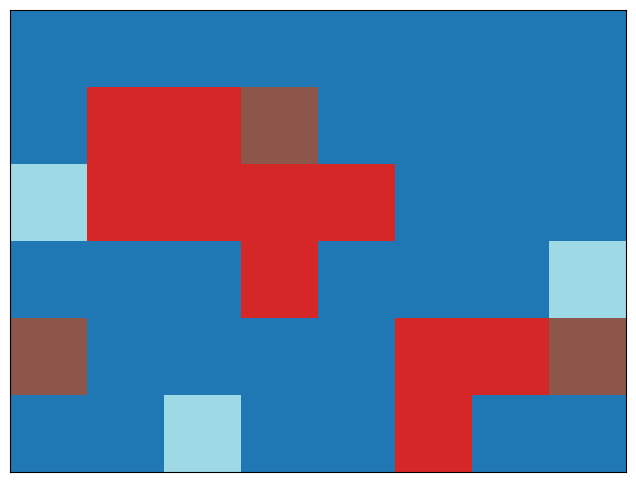

In [46]:
# PARÁMETROS
WIDTH = 8
HEIGHT = 6
FIREFIGHTERS = 6
# Cargar datos de input.txt usando una cadena sin procesar
with open(r'./Input.txt', 'r') as file:
    lines = file.readlines()


WALLS = []
for i in range(6):
    row = []
    cells = lines[i].strip().split()
    for cell in cells:
        walls = []
        for c in cell:
            if c == '1':
                walls.append(2)
            else:
                walls.append(0)

        row.append(walls)
    WALLS.append(row)

POI = []
for i in range(6, 9):
    r, c, ptype = lines[i].strip().split()
    POI.append((int(r) - 1, int(c) - 1, ptype == 'v', False))

FIRE = []
for i in range(9, 19):
    r, c = map(int, lines[i].strip().split())
    FIRE.append((r - 1, c - 1))

DOORS = {}
DOORS_CONNECTED = {}
for i in range(19, 27):
    r1, c1, r2, c2 = map(int, lines[i].strip().split())
    r1, c1, r2, c2 = r1 - 1, c1 - 1, r2 - 1, c2 - 1
    DOORS[(r1, c1, r2, c2)] = False
    DOORS_CONNECTED[(r1, c1)] = (r2, c2)
    DOORS_CONNECTED[(r2, c2)] = (r1, c1)
    
    if 0 <= r1 < 6 and 0 <= c1 < 8 and 0 <= r2 < 6 and 0 <= c2 < 8:
        # Puerta en la misma columna
        if r1 == r2:
            if c1 < c2:
                # Derecha de r1, c1
                if len(WALLS[r1][c1]) > 1:
                    WALLS[r1][c1][1] = 'door'
                # Izquierda de r2, c2
                if len(WALLS[r2][c2]) > 3:
                    WALLS[r2][c2][3] = 'door'
            else:
                # Izquierda de r1, c1
                if len(WALLS[r1][c1]) > 3:
                    WALLS[r1][c1][3] = 'door'
                # Derecha de r2, c2
                if len(WALLS[r2][c2]) > 1:
                    WALLS[r2][c2][1] = 'door'
        # Puerta en la misma columna
        else:
            if r1 < r2:
                # Abajo de r1, c1
                if len(WALLS[r1][c1]) > 2:
                    WALLS[r1][c1][2] = 'door'
                # Arriba de r2, c2
                if len(WALLS[r2][c2]) > 0:
                    WALLS[r2][c2][0] = 'door'
            else:
                # Arriba de r1, c1
                if len(WALLS[r1][c1]) > 0:
                    WALLS[r1][c1][0] = 'door'
                # Abajo de r2, c2
                if len(WALLS[r2][c2]) > 2:
                    WALLS[r2][c2][2] = 'door'

# Procesar puntos de entrada
ENTRANCES = []
for i in range(27, 31):
    r, c = map(int, lines[i].strip().split())
    r, c = r - 1, c - 1  # Ajustar índices para Python
    ENTRANCES.append((r, c))
    
    # Asignar 'entrance' en la pared adecuada dependiendo de la posición
    if 0 <= r < 6 and 0 <= c < 8:
        if r == 0:  # Entrada en la parte superior
            WALLS[r][c][0] = 'entrance'
        elif r == 6 - 1:  # Entrada en la parte inferior
            WALLS[r][c][2] = 'entrance'
        elif c == 0:  # Entrada en la parte izquierda
            WALLS[r][c][3] = 'entrance'
        elif c == 8 - 1:  # Entrada en la parte derecha
            WALLS[r][c][1] = 'entrance'
# SIMULACIÓN
for sim in range(1):
    model = OrderingModel(WIDTH, HEIGHT, FIREFIGHTERS, FIRE, WALLS, DOORS, DOORS_CONNECTED, ENTRANCES, POI)
    steps = 0
    while  model.damage < 24 and model.total_deseases < 4 and model.total_saved_victims < 7:
        model.step()
        steps += 1

    if model.damage >= 24:
        print("BUILDING COLAPSED")
        print("GAME OVER")
    elif model.total_deseases >= 3:
        print("4 DISEASES")
        print("GAME OVER")
    elif model.total_saved_victims >= 7:
        print("VICTORY!!!!")

    dataframe = model.datacollector.get_model_vars_dataframe()

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    patch = plt.imshow(dataframe.iloc[0][0], cmap=plt.cm.tab20)

    # Animación
    def animate(i):
        patch.set_data(dataframe.iloc[i][0])

    anim = animation.FuncAnimation(fig, animate, frames=len(dataframe))
    plt.show()

In [47]:
anim

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


/var/folders/6z/dh79mb414f138w470bm8_pf40000gn/T/ipykernel_35702/2477925381.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(dataframe.iloc[i][0])


In [49]:
from http.server import BaseHTTPRequestHandler, HTTPServer
import logging
import json

# PARÁMETROS
WIDTH = 8
HEIGHT = 6
FIREFIGHTERS = 6
# Cargar datos de input.txt usando una cadena sin procesar
with open(r'./Input.txt', 'r') as file:
    lines = file.readlines()


WALLS = []
for i in range(6):
    row = []
    cells = lines[i].strip().split()
    for cell in cells:
        walls = []
        for c in cell:
            if c == '1':
                walls.append(2)
            else:
                walls.append(0)

        row.append(walls)
    WALLS.append(row)

POI = []
for i in range(6, 9):
    r, c, ptype = lines[i].strip().split()
    POI.append((int(r) - 1, int(c) - 1, ptype == 'v', False))

FIRE = []
for i in range(9, 19):
    r, c = map(int, lines[i].strip().split())
    FIRE.append((r - 1, c - 1))

DOORS = {}
DOORS_CONNECTED = {}
for i in range(19, 27):
    r1, c1, r2, c2 = map(int, lines[i].strip().split())
    r1, c1, r2, c2 = r1 - 1, c1 - 1, r2 - 1, c2 - 1
    DOORS[(r1, c1, r2, c2)] = False
    DOORS_CONNECTED[(r1, c1)] = (r2, c2)
    DOORS_CONNECTED[(r2, c2)] = (r1, c1)
    
    if 0 <= r1 < 6 and 0 <= c1 < 8 and 0 <= r2 < 6 and 0 <= c2 < 8:
        # Puerta en la misma columna
        if r1 == r2:
            if c1 < c2:
                # Derecha de r1, c1
                if len(WALLS[r1][c1]) > 1:
                    WALLS[r1][c1][1] = 'door'
                # Izquierda de r2, c2
                if len(WALLS[r2][c2]) > 3:
                    WALLS[r2][c2][3] = 'door'
            else:
                # Izquierda de r1, c1
                if len(WALLS[r1][c1]) > 3:
                    WALLS[r1][c1][3] = 'door'
                # Derecha de r2, c2
                if len(WALLS[r2][c2]) > 1:
                    WALLS[r2][c2][1] = 'door'
        # Puerta en la misma columna
        else:
            if r1 < r2:
                # Abajo de r1, c1
                if len(WALLS[r1][c1]) > 2:
                    WALLS[r1][c1][2] = 'door'
                # Arriba de r2, c2
                if len(WALLS[r2][c2]) > 0:
                    WALLS[r2][c2][0] = 'door'
            else:
                # Arriba de r1, c1
                if len(WALLS[r1][c1]) > 0:
                    WALLS[r1][c1][0] = 'door'
                # Abajo de r2, c2
                if len(WALLS[r2][c2]) > 2:
                    WALLS[r2][c2][2] = 'door'

# Procesar puntos de entrada
ENTRANCES = []
for i in range(27, 31):
    r, c = map(int, lines[i].strip().split())
    r, c = r - 1, c - 1  # Ajustar índices para Python
    ENTRANCES.append((r, c))
    
    # Asignar 'entrance' en la pared adecuada dependiendo de la posición
    if 0 <= r < 6 and 0 <= c < 8:
        if r == 0:  # Entrada en la parte superior
            WALLS[r][c][0] = 'entrance'
        elif r == 6 - 1:  # Entrada en la parte inferior
            WALLS[r][c][2] = 'entrance'
        elif c == 0:  # Entrada en la parte izquierda
            WALLS[r][c][3] = 'entrance'
        elif c == 8 - 1:  # Entrada en la parte derecha
            WALLS[r][c][1] = 'entrance'

class Server(BaseHTTPRequestHandler):
    def __init__(self, model, *args, **kwargs):
        self.model = model
        super().__init__(*args, **kwargs) 
    
    def _set_response(self):
        self.send_response(200)
        self.send_header('Content-type', 'application/json')
        self.end_headers()
        
    def do_GET(self):
        if (self.path == '/map'):
            response = {
                "walls": self.model.walls_grid.tolist(),
                "fires": self.model.fires_grid.tolist(),
                "poi" : self.model.POI_pos()
            }

            self._set_response()
            self.wfile.write(str(response).encode('utf-8'))
        elif (self.path == '/step'):
            self.model.step()
            response = {
                "moves": self.model.moves
            }

            self._set_response()
            self.wfile.write(str(response).encode('utf-8'))


def run(model, server_class=HTTPServer, handler_class=Server, port=8585):
    logging.basicConfig(level=logging.INFO)
    server_address = ('', port)

    #Crea el server y pasa el modelo a la handler class
    httpd = server_class(server_address, lambda *args, **kwargs: handler_class(model, *args, **kwargs))
    logging.info("Starting httpd...\n") # HTTPD is HTTP Daemon!
    try:
        httpd.serve_forever()
    except KeyboardInterrupt:   # CTRL+C stops the server
        pass
    httpd.server_close()
    logging.info("Stopping httpd...\n")

if __name__ == '__main__':
    model = OrderingModel(WIDTH, HEIGHT, FIREFIGHTERS, FIRE, WALLS, DOORS, DOORS_CONNECTED, ENTRANCES, POI)
    run(model)

INFO:root:Starting httpd...

127.0.0.1 - - [03/Sep/2024 18:52:51] "GET /map HTTP/1.1" 200 -
127.0.0.1 - - [03/Sep/2024 18:53:12] "GET /map HTTP/1.1" 200 -


Llamando al step del agente 0 antes del schedule.
Agente0 tiene estado heading_to_POI
Vamos a POI
No tengo camino
(4, 7)
[(4, 7)]
Este es el camino que tengo [(4, 7)]
Agente 0 encontró un obstáculo o peligro en (4, 7), recalculando camino.
Agente 0 tiene sus action points 4. sus estado es heading_to_POI
Step modelo


127.0.0.1 - - [03/Sep/2024 18:53:15] "GET /step HTTP/1.1" 200 -


Llamando al step del agente 1 antes del schedule.
Agente1 tiene estado heading_to_POI
Vamos a POI
No tengo camino
(4, 7)
[(4, 7)]
Este es el camino que tengo [(4, 7)]
Agente 1 se movió a (4, 7)
Agente 1 llegó al POI (4, 7)
Vamos a la entrada
Camino a la entrada calculado: [(3, 7)]
Agente 1 se movió a (3, 7)
Agente 1 llegó a la entrada (3, 7)
Vamos a POI
No tengo camino
(1, 3)
[(2, 6), (1, 5), (1, 4), (1, 3)]
Este es el camino que tengo [(2, 6), (1, 5), (1, 4), (1, 3)]
Agente 1 encontró un obstáculo o peligro en (2, 6), recalculando camino.
Agente 1 tiene sus action points 2. sus estado es heading_to_POI
Step modelo
Llamando al step del agente 2 antes del schedule.
Agente2 tiene estado heading_to_POI
Vamos a POI
No tengo camino
(1, 3)
[(2, 6), (1, 5), (1, 4), (1, 3)]
Este es el camino que tengo [(2, 6), (1, 5), (1, 4), (1, 3)]
Agente 2 encontró un obstáculo o peligro en (2, 6), recalculando camino.
Agente 2 tiene sus action points 4. sus estado es heading_to_POI
Step modelo


127.0.0.1 - - [03/Sep/2024 18:53:17] "GET /step HTTP/1.1" 200 -
127.0.0.1 - - [03/Sep/2024 18:53:17] "GET /step HTTP/1.1" 200 -


Llamando al step del agente 3 antes del schedule.
Agente3 tiene estado extinguishing
exitingir
safe_moves  [(1, 0), (2, 1), (3, 0)]
fire_around  [(2, 1)]
Agente 3 apagó el fuego en la celda (2, 1)
Agente 3 se movió a (1, 0). Quedan 1 puntos de acción.
exitingir
safe_moves  [(0, 0), (2, 0)]
fire_around  [(1, 1)]
Agente 3 se movió a (2, 0). Quedan 0 puntos de acción.
Agente 3 tiene sus action points 0. sus estado es extinguishing
Step modelo


127.0.0.1 - - [03/Sep/2024 18:53:18] "GET /step HTTP/1.1" 200 -


Llamando al step del agente 4 antes del schedule.
Agente4 tiene estado extinguishing
exitingir
safe_moves  [(4, 2), (5, 1), (5, 3)]
fire_around  []
Agente 4 se movió a (5, 1). Quedan 3 puntos de acción.
exitingir
safe_moves  [(4, 1), (5, 0), (5, 2)]
fire_around  []
Agente 4 se movió a (5, 0). Quedan 2 puntos de acción.
exitingir
safe_moves  [(4, 0), (5, 1)]
fire_around  []
Agente 4 se movió a (4, 0). Quedan 1 puntos de acción.
exitingir
safe_moves  [(4, 1), (5, 0)]
fire_around  []
Agente 4 se movió a (5, 0). Quedan 0 puntos de acción.
Agente 4 tiene sus action points 0. sus estado es extinguishing
Step modelo
Llamando al step del agente 5 antes del schedule.
Agente5 tiene estado extinguishing
exitingir
safe_moves  [(0, 6), (1, 5)]
fire_around  []
Agente 5 se movió a (0, 6). Quedan 3 puntos de acción.
exitingir
safe_moves  [(0, 5), (0, 7), (1, 6)]
fire_around  []
Agente 5 se movió a (0, 5). Quedan 2 puntos de acción.
exitingir
safe_moves  [(0, 6), (1, 5)]
fire_around  []
Agente 5 se mov

127.0.0.1 - - [03/Sep/2024 18:53:19] "GET /step HTTP/1.1" 200 -
127.0.0.1 - - [03/Sep/2024 18:53:19] "GET /step HTTP/1.1" 200 -


Llamando al step del agente 0 antes del schedule.
Agente0 tiene estado heading_to_POI
Vamos a POI
Este es el camino que tengo [(4, 7)]
Agente 0 se movió a (4, 7)
Agente 0 llegó al POI (4, 7)
Vamos a la entrada
Camino a la entrada calculado: [(3, 7)]
Agente 0 se movió a (3, 7)
Agente 0 llegó a la entrada (3, 7)
Vamos a POI
No tengo camino
(1, 3)
[(2, 6), (1, 5), (1, 4), (1, 3)]
Este es el camino que tengo [(2, 6), (1, 5), (1, 4), (1, 3)]
Agente 0 encontró un obstáculo o peligro en (2, 6), recalculando camino.
Agente 0 tiene sus action points 2. sus estado es heading_to_POI
Step modelo


127.0.0.1 - - [03/Sep/2024 18:53:25] "GET /step HTTP/1.1" 200 -


Llamando al step del agente 1 antes del schedule.
Agente1 tiene estado heading_to_POI
Vamos a POI
Este es el camino que tengo [(2, 6), (1, 5), (1, 4), (1, 3)]
Agente 1 encontró un obstáculo o peligro en (2, 6), recalculando camino.
Agente 1 tiene sus action points 4. sus estado es heading_to_POI
Step modelo


127.0.0.1 - - [03/Sep/2024 18:53:28] "GET /step HTTP/1.1" 200 -


Llamando al step del agente 2 antes del schedule.
Agente2 tiene estado heading_to_POI
Vamos a POI
Este es el camino que tengo [(2, 6), (1, 5), (1, 4), (1, 3)]
Agente 2 encontró un obstáculo o peligro en (2, 6), recalculando camino.
Agente 2 tiene sus action points 4. sus estado es heading_to_POI
Step modelo
Llamando al step del agente 3 antes del schedule.
Agente3 tiene estado extinguishing
exitingir
safe_moves  [(1, 0), (2, 1), (3, 0)]
fire_around  []
Agente 3 se movió a (1, 0). Quedan 3 puntos de acción.
exitingir
safe_moves  [(0, 0), (1, 1), (2, 0)]
fire_around  [(0, 0), (1, 1)]
Agente 3 apagó el fuego en la celda (1, 1)
Agente 3 se movió a (2, 0). Quedan 0 puntos de acción.
Agente 3 tiene sus action points 0. sus estado es extinguishing
Step modelo


127.0.0.1 - - [03/Sep/2024 18:53:30] "GET /step HTTP/1.1" 200 -
127.0.0.1 - - [03/Sep/2024 18:53:30] "GET /step HTTP/1.1" 200 -


Llamando al step del agente 4 antes del schedule.
Agente4 tiene estado extinguishing
exitingir
safe_moves  [(4, 0), (5, 1)]
fire_around  []
Agente 4 se movió a (4, 0). Quedan 3 puntos de acción.
exitingir
safe_moves  [(4, 1), (5, 0)]
fire_around  []
Agente 4 se movió a (4, 1). Quedan 2 puntos de acción.
exitingir
safe_moves  [(4, 0), (4, 2), (5, 1)]
fire_around  []
Agente 4 se movió a (5, 1). Quedan 1 puntos de acción.
exitingir
safe_moves  [(4, 1), (5, 0), (5, 2)]
fire_around  []
Agente 4 se movió a (4, 1). Quedan 0 puntos de acción.
Agente 4 tiene sus action points 0. sus estado es extinguishing
Step modelo
Llamando al step del agente 5 antes del schedule.
Agente5 tiene estado extinguishing
exitingir
safe_moves  [(0, 4), (1, 3), (1, 5)]
fire_around  []
Agente 5 se movió a (1, 5). Quedan 3 puntos de acción.
exitingir
safe_moves  [(0, 5), (1, 4), (1, 6)]
fire_around  []
Agente 5 se movió a (0, 5). Quedan 2 puntos de acción.
exitingir
safe_moves  [(0, 6), (1, 5)]
fire_around  []
Agente 

127.0.0.1 - - [03/Sep/2024 18:53:32] "GET /step HTTP/1.1" 200 -
127.0.0.1 - - [03/Sep/2024 18:53:32] "GET /step HTTP/1.1" 200 -


Llamando al step del agente 0 antes del schedule.
Agente0 tiene estado heading_to_POI
Vamos a POI
Este es el camino que tengo [(2, 6), (1, 5), (1, 4), (1, 3)]
Agente 0 encontró un obstáculo o peligro en (2, 6), recalculando camino.
Agente 0 tiene sus action points 4. sus estado es heading_to_POI
Step modelo
Llamando al step del agente 1 antes del schedule.
Agente1 tiene estado heading_to_POI
Vamos a POI
Este es el camino que tengo [(2, 6), (1, 5), (1, 4), (1, 3)]
Agente 1 encontró un obstáculo o peligro en (2, 6), recalculando camino.
Agente 1 tiene sus action points 4. sus estado es heading_to_POI
Step modelo


127.0.0.1 - - [03/Sep/2024 18:53:34] "GET /step HTTP/1.1" 200 -
127.0.0.1 - - [03/Sep/2024 18:53:34] "GET /step HTTP/1.1" 200 -


Llamando al step del agente 2 antes del schedule.
Agente2 tiene estado heading_to_POI
Vamos a POI
Este es el camino que tengo [(2, 6), (1, 5), (1, 4), (1, 3)]
Agente 2 encontró un obstáculo o peligro en (2, 6), recalculando camino.
Agente 2 tiene sus action points 4. sus estado es heading_to_POI
Step modelo


127.0.0.1 - - [03/Sep/2024 18:53:42] "GET /step HTTP/1.1" 200 -


Llamando al step del agente 3 antes del schedule.
Agente3 tiene estado extinguishing
exitingir
safe_moves  [(1, 0), (2, 1), (3, 0)]
fire_around  [(1, 0)]
Agente 3 apagó el fuego en la celda (1, 0)
Agente 3 se movió a (1, 0). Quedan 1 puntos de acción.
exitingir
safe_moves  [(2, 0)]
fire_around  [(0, 0), (1, 1)]
Agente 3 se movió a (2, 0). Quedan 0 puntos de acción.
Agente 3 tiene sus action points 0. sus estado es extinguishing
Step modelo
Llamando al step del agente 4 antes del schedule.
Agente4 tiene estado extinguishing
exitingir
safe_moves  [(4, 0), (4, 2), (5, 1)]
fire_around  []
Agente 4 se movió a (5, 1). Quedan 3 puntos de acción.
exitingir
safe_moves  [(4, 1), (5, 0), (5, 2)]
fire_around  []
Agente 4 se movió a (4, 1). Quedan 2 puntos de acción.
exitingir
safe_moves  [(4, 0), (4, 2), (5, 1)]
fire_around  []
Agente 4 se movió a (5, 1). Quedan 1 puntos de acción.
exitingir
safe_moves  [(4, 1), (5, 0), (5, 2)]
fire_around  []
Agente 4 se movió a (5, 2). Quedan 0 puntos de acción.

127.0.0.1 - - [03/Sep/2024 18:53:46] "GET /step HTTP/1.1" 200 -
127.0.0.1 - - [03/Sep/2024 18:53:46] "GET /step HTTP/1.1" 200 -


Llamando al step del agente 5 antes del schedule.
Agente5 tiene estado extinguishing
exitingir
safe_moves  [(0, 6), (1, 5), (1, 7)]
fire_around  [(1, 7)]
Agente 5 apagó el fuego en la celda (1, 7)
Agente 5 se movió a (1, 7). Quedan 1 puntos de acción.
exitingir
safe_moves  [(0, 7), (1, 6), (2, 7)]
fire_around  []
Agente 5 se movió a (1, 6). Quedan 0 puntos de acción.
Agente 5 tiene sus action points 0. sus estado es extinguishing
Step modelo


127.0.0.1 - - [03/Sep/2024 18:53:48] "GET /step HTTP/1.1" 200 -
